# DQN 訓練
使用：Double DQN、reward clipping、gradient clipping、epsilon 指數衰減、target sync、frame stacking

In [1]:
# ✅ 自動安裝 ALE + ROM + 測試 MsPacman 是否能載入
%pip install 'gym[atari,accept-rom-license]' ale-py AutoROM -q
!AutoROM --accept-license
import gym
env = gym.make('ALE/MsPacman-v5', render_mode='rgb_array')
obs, _ = env.reset()
print('✅ MsPacman 環境成功載入，畫面大小：', obs.shape)
env.close()

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'gym[atari,accept-rom-license]'": Expected package name at the start of dependency specifier
    'gym[atari,accept-rom-license]'
    ^


AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	C:\Users\waychen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\AutoROM\roms

Existing ROMs will be overwritten.
✅ MsPacman 環境成功載入，畫面大小： (210, 160, 3)


In [ ]:
%pip install gym[atari] opencv-python moviepy imageio -q

In [2]:
import gym, cv2, random, os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
from gym.wrappers import RecordVideo

In [3]:
# 畫面預處理與 frame stacking
def preprocess(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = cv2.resize(obs, (84, 84))
    return obs / 255.0

def stack_frames(frames):
    return np.stack(frames, axis=0)

In [4]:
# DQN 架構
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(3136, 512), nn.ReLU(), nn.Linear(512, num_actions)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [5]:
# 記憶體
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Experience(*args))
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        return map(lambda x: torch.tensor(np.array(x)), zip(*samples))
    def __len__(self): return len(self.buffer)

In [ ]:
# 超參數
ENV_NAME = 'ALE/MsPacman-v5'
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 20000
MIN_REPLAY_SIZE = 5000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 100000
LR = 1e-4
TARGET_UPDATE_FREQ = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# 初始化
env = gym.make(ENV_NAME, render_mode='rgb_array')
env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: e % 10 == 0)
num_actions = env.action_space.n
policy_net = DQN((4,84,84), num_actions).to(device)
target_net = DQN((4,84,84), num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(BUFFER_SIZE)
steps_done = 0

C:\Users\waychen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\code\pythoncode\DQN-project\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [8]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

C:\Users\waychen\AppData\Local\Temp\ipykernel_21228\439357633.py:1: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):


In [9]:
# 訓練主迴圈
all_rewards = []  # ⬅️ 記錄每局總得分
for episode in range(100):
    obs, _ = env.reset()
    obs = preprocess(obs)
    frames = [obs] * 4
    state = stack_frames(frames)
    total_reward = 0
    done = False
    while not done:
        epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
        if random.random() < epsilon:
            action = random.randrange(num_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(1).item()

        next_obs, reward, done, _, _ = env.step(action)
        reward = np.clip(reward, -1, 1)
        next_obs = preprocess(next_obs)
        frames.pop(0); frames.append(next_obs)
        next_state = stack_frames(frames)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps_done += 1

        if len(replay_buffer) > MIN_REPLAY_SIZE:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
            states = states.float().to(device)
            actions = actions.long().unsqueeze(1).to(device)
            rewards = rewards.float().to(device)
            next_states = next_states.float().to(device)
            dones = dones.float().to(device)

            q_values = policy_net(states).gather(1, actions).squeeze(1)
            with torch.no_grad():
                next_actions = policy_net(next_states).argmax(1, keepdim=True)
                next_q = target_net(next_states).gather(1, next_actions).squeeze(1)
                target_q = rewards + GAMMA * next_q * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

            if steps_done % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode+1} - Reward: {total_reward:.1f}")
    all_rewards.append(total_reward)  # ⬅️ 儲存這局的總分
env.close()

C:\Users\waychen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
C:\Users\waychen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-0.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-0.mp4
Episode 1 - Reward: 22.0
Episode 2 - Reward: 28.0
Episode 3 - Reward: 22.0
Episode 4 - Reward: 25.0
Episode 5 - Reward: 28.0
Episode 6 - Reward: 27.0
Episode 7 - Reward: 31.0
Episode 8 - Reward: 20.0
Episode 9 - Reward: 26.0
Episode 10 - Reward: 20.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-10.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-10.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-10.mp4
Episode 11 - Reward: 28.0
Episode 12 - Reward: 21.0
Episode 13 - Reward: 20.0
Episode 14 - Reward: 21.0
Episode 15 - Reward: 25.0
Episode 16 - Reward: 28.0
Episode 17 - Reward: 29.0
Episode 18 - Reward: 14.0
Episode 19 - Reward: 24.0
Episode 20 - Reward: 15.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-20.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-20.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-20.mp4
Episode 21 - Reward: 22.0
Episode 22 - Reward: 20.0
Episode 23 - Reward: 22.0
Episode 24 - Reward: 30.0
Episode 25 - Reward: 37.0
Episode 26 - Reward: 29.0
Episode 27 - Reward: 42.0
Episode 28 - Reward: 20.0
Episode 29 - Reward: 33.0
Episode 30 - Reward: 16.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-30.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-30.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-30.mp4
Episode 31 - Reward: 45.0
Episode 32 - Reward: 40.0
Episode 33 - Reward: 38.0
Episode 34 - Reward: 33.0
Episode 35 - Reward: 26.0
Episode 36 - Reward: 23.0
Episode 37 - Reward: 18.0
Episode 38 - Reward: 38.0
Episode 39 - Reward: 34.0
Episode 40 - Reward: 36.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-40.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-40.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-40.mp4
Episode 41 - Reward: 28.0
Episode 42 - Reward: 34.0
Episode 43 - Reward: 37.0
Episode 44 - Reward: 23.0
Episode 45 - Reward: 24.0
Episode 46 - Reward: 29.0
Episode 47 - Reward: 31.0
Episode 48 - Reward: 28.0
Episode 49 - Reward: 25.0
Episode 50 - Reward: 26.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-50.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-50.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-50.mp4
Episode 51 - Reward: 27.0
Episode 52 - Reward: 30.0
Episode 53 - Reward: 20.0
Episode 54 - Reward: 22.0
Episode 55 - Reward: 31.0
Episode 56 - Reward: 15.0
Episode 57 - Reward: 39.0
Episode 58 - Reward: 35.0
Episode 59 - Reward: 32.0
Episode 60 - Reward: 31.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-60.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-60.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-60.mp4
Episode 61 - Reward: 45.0
Episode 62 - Reward: 27.0
Episode 63 - Reward: 41.0
Episode 64 - Reward: 39.0
Episode 65 - Reward: 28.0
Episode 66 - Reward: 23.0
Episode 67 - Reward: 31.0
Episode 68 - Reward: 53.0
Episode 69 - Reward: 17.0
Episode 70 - Reward: 26.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-70.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-70.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-70.mp4
Episode 71 - Reward: 36.0
Episode 72 - Reward: 29.0
Episode 73 - Reward: 28.0
Episode 74 - Reward: 27.0
Episode 75 - Reward: 29.0
Episode 76 - Reward: 27.0
Episode 77 - Reward: 31.0
Episode 78 - Reward: 25.0
Episode 79 - Reward: 25.0
Episode 80 - Reward: 32.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-80.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-80.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-80.mp4
Episode 81 - Reward: 30.0
Episode 82 - Reward: 25.0
Episode 83 - Reward: 26.0
Episode 84 - Reward: 28.0
Episode 85 - Reward: 37.0
Episode 86 - Reward: 55.0
Episode 87 - Reward: 32.0
Episode 88 - Reward: 25.0
Episode 89 - Reward: 37.0
Episode 90 - Reward: 36.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-90.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-90.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-90.mp4
Episode 91 - Reward: 48.0
Episode 92 - Reward: 34.0
Episode 93 - Reward: 31.0
Episode 94 - Reward: 27.0
Episode 95 - Reward: 31.0
Episode 96 - Reward: 24.0
Episode 97 - Reward: 30.0
Episode 98 - Reward: 48.0
Episode 99 - Reward: 19.0
Episode 100 - Reward: 36.0
MoviePy - Building video d:\code\pythoncode\DQN-project\videos\rl-video-episode-100.mp4.
MoviePy - Writing video d:\code\pythoncode\DQN-project\videos\rl-video-episode-100.mp4



MoviePy - Done !
MoviePy - video ready d:\code\pythoncode\DQN-project\videos\rl-video-episode-100.mp4


C:\Users\waychen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


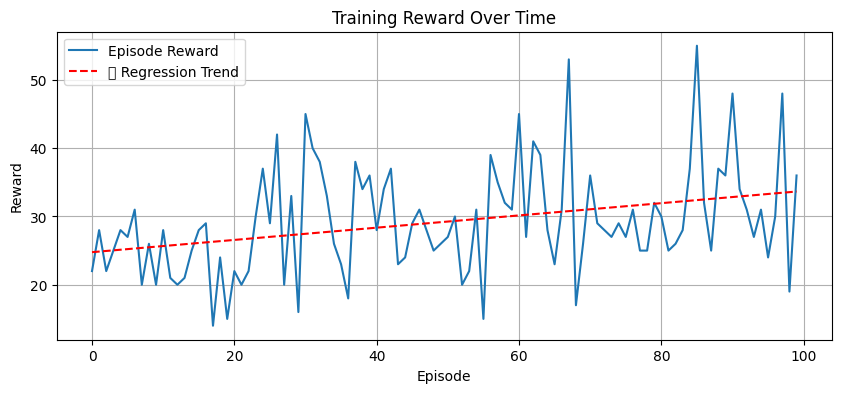

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ⬅️ 假設 all_rewards 已在訓練過程中累積了每一局的總得分
episodes = np.arange(len(all_rewards))  # x 軸為第幾局
slope, intercept, r_value, p_value, std_err = linregress(episodes, all_rewards)
trend = slope * episodes + intercept 
plt.figure(figsize=(10,4))
plt.plot(all_rewards, label="Episode Reward")
plt.plot(trend, label='Regression Trend', linestyle='--', color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Reward Over Time")
plt.grid(True)
plt.legend()
plt.show()